In [1]:
from IPython.utils import io
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion


with io.capture_output() as captured:
  if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
      print("Python3 is needed!");
      print("How to fix: Runtime/Change_runtime_type/Python 3");
      sys.exit()
      
  try:
      from dolfin import *; from mshr import *
  except ImportError as e:
      !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
      !add-apt-repository -y ppa:fenics-packages/fenics
      !apt-get update -qq
      !apt install -y --no-install-recommends fenics
      from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files

dolfin version: 2019.1.0


In [35]:
class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], -1)

class Top(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 4.0)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 5.0)


# Define domain
domain = Rectangle(Point(0, -1), Point(5, 4))


# Initialize sub-domain instances
top = Top()
left = Left()
right = Right()
bottom = Bottom()

#initialize mesh
mesh = generate_mesh(domain, 100)

# Initialize mesh function for interior domains
domains = MeshFunction("size_t", mesh,2)

boundaries = MeshFunction("size_t", mesh,1)
boundaries.set_all(0)
left.mark(boundaries, 1)
top.mark(boundaries, 2)
right.mark(boundaries, 3)
bottom.mark(boundaries, 4)




In [36]:
omega=2.0
theta=pi/2
alpha=2 #damping coefficient 
# Define function G such that G \cdot n = g
#class BoundarySource(UserExpression):
  #  def __init__(self, mesh, **kwargs):
    #    self.mesh = mesh
     #   super().__init__(**kwargs)
    #def eval_cell(self, values, x, ufc_cell):
    #    cell = Cell(self.mesh, ufc_cell.index)
     #   n = cell.normal(ufc_cell.local_facet)
     #   g = sin(2*pi*omega*(cos(theta)*x[0]+sin(theta)*x[1]))
     #   values[0] = g*n[0]
    #    values[1] = g*n[1]
   # def value_shape(self):
     #   return (2,)

#G = BoundarySource(mesh, degree=2)    

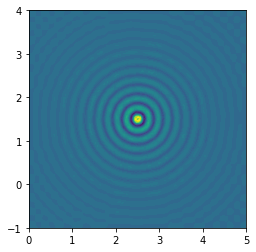

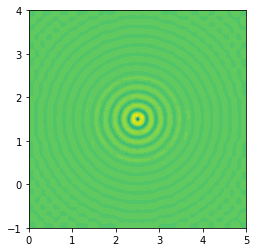

In [38]:
#Helmholtz equation with Dirichlet boundary conditions
#def Helmholtz(mesh, frequency, sigma=Constant(0), c=343):
    
# squared wavenumber
k = Constant(2*pi*5)
alpha=2 #damping coefficient

# Define finite elements spaces and build mixed space
V=VectorFunctionSpace(mesh,"CG",1,dim=2)

# Define Dirichlet boundary conditions at top(2) and (bottom)(4), right(3), left (1) boundaries
bcs = [DirichletBC(V, (0.0,0), boundaries, 1), DirichletBC(V, (0.0,0), boundaries, 2), 
DirichletBC(V, (0.0,0), boundaries, 3), DirichletBC(V, (0,0), boundaries, 4)]

# define variational problem/weak form as a vector
(u_r, u_i) = TrialFunction(V)
(v_r, v_i) = TestFunction(V)

a_r = (-inner(grad(u_r), grad(v_r)) + k**2*u_r*v_r-alpha*k*u_i*v_r) * dx
a_i = (-inner(grad(u_i), grad(v_i)) + k**2*u_i*v_i + k*alpha*u_r*v_i) * dx
L_r = Expression("sin(x[0])", degree=2) * v_r * dx #look up degree
L_i = Constant(0) * v_i * dx

a = a_r + a_i
L = L_r + L_i
A, b = assemble_system(a, L, bcs) #include boundary conditions (mass matrix A)

#define inhomogenity
delta = PointSource(V, Point(2.5,1.5), 1)  # negative amplitude accounts for -v in inhomogeneous wave equation (1/c^2)(u''-grad^2u)=-v
delta.apply(b)



# Compute solution
u = Function(V)
solve(A, u.vector(), b)
(u_r, u_i) = u.split()

# Plot sigma and u
plt.figure()
plot(u_r)

plt.figure()
plot(u_i)

plt.show()
# return u_r, u_i

In [ ]:
def plot_solution(w):
    '''plots solution of FEM-based simulation'''
    fig = plt.figure(figsize=(10,10))
    fig = plot(w)
    plt.title(r'$w(\mathbf{x},\omega)$') #x is vector
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.colorbar(fig, fraction=0.04, pad=0.04);

In [ ]:
# define geometry and mesh

w=Helmholtz(mesh, omega, sigma=Constant(2*pi*omega))

RuntimeError: ignored